In [1]:
#Importing Packages
import xarray as xr
import cartopy.crs as ccrs
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import skgstat as skg

from src.helper_functions import grid_coords_to_2d_latlon_coords
from src.helper_functions import create_mask

In [2]:
#Loading climate data
base_path = '/home/jez/Bias_Correction/'
climate_path = f'{base_path}data/ProcessedData/MetUM_Daily_TAS.nc'
mask_path = f'{base_path}data/ProcessedData/MetUM_044_Masks.nc'

ds_climate = xr.open_dataset(climate_path)
ds_mask = xr.open_dataset(mask_path)

ds = xr.merge([ds_climate,ds_mask])


ERROR:fiona._env:PROJ: proj_identify: /home/jez/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


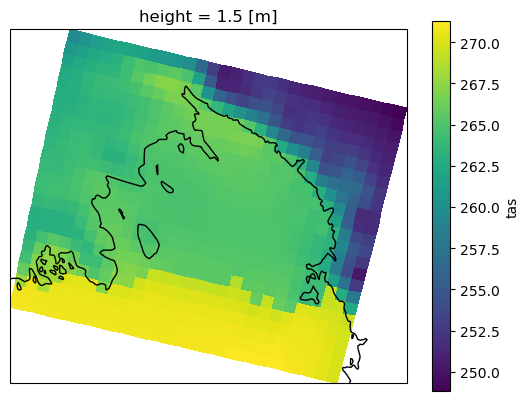

In [3]:
#Plotting Masked Climate Data and Antarctica Shapefile and Region Shapefile
map_proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=-90, globe=None)

da = ds.tas.isel(time=(ds.time.dt.month == 1))
masked_da = da.where(ds.region_mask)
masked_da = masked_da.dropna('grid_latitude','all').dropna('grid_longitude','all')

masked_da.mean('time').plot(x='longitude',y='latitude',
    subplot_kws={"projection": map_proj},
    transform=ccrs.PlateCarree())

plt.gca().coastlines()

In [9]:
masked_da

<xarray.DataArray 'tas' (time: 1178, grid_latitude: 24, grid_longitude: 29)>
array([[[269.2832 , 269.32227, 269.46875, ..., 270.375  , 270.0078 ,
         270.55273],
        [269.41602, 269.25586, 269.2793 , ..., 270.31836, 270.11133,
         270.42383],
        [263.7168 , 268.6172 , 265.20312, ..., 270.19922, 270.02344,
         270.61914],
        ...,
        [263.57617, 264.14453, 264.80664, ..., 254.97461, 254.67773,
         254.17578],
        [262.4961 , 263.2246 , 264.07617, ..., 254.28906, 253.91211,
         253.37695],
        [261.28516, 262.22852, 263.22266, ..., 253.39258, 252.95312,
         252.45508]],

       [[269.11523, 269.14258, 269.21875, ..., 270.84766, 270.95312,
         270.91992],
        [268.88086, 268.88672, 269.17578, ..., 270.85938, 270.9297 ,
         270.85742],
        [262.43164, 267.70898, 264.2539 , ..., 270.98047, 271.01367,
         270.97852],
...
        [256.02734, 256.40234, 256.91797, ..., 246.01172, 245.67969,
         245.125  ],
        [255.23242, 255.89258, 256.78125, ..., 245.41797, 245.01953,
         244.49219],
        [254.19336, 255.05273, 256.11133, ..., 244.69727, 244.27539,
         243.9082 ]],

       [[270.0586 , 270.1621 , 270.31445, ..., 270.55273, 268.85742,
         267.28125],
        [268.83008, 269.10547, 269.48828, ..., 270.2754 , 268.7578 ,
         267.00977],
        [261.3828 , 267.89453, 261.1875 , ..., 269.94922, 268.5547 ,
         266.72266],
        ...,
        [257.3379 , 257.53516, 257.93164, ..., 244.58984, 244.49805,
         244.1914 ],
        [256.74414, 257.09766, 257.76172, ..., 244.97461, 244.7168 ,
         244.31445],
        [256.04102, 256.66602, 257.57227, ..., 245.01758, 244.6211 ,
         244.24219]]], dtype=float32)
Coordinates:
  * grid_latitude   (grid_latitude) float32 -14.52 -14.08 -13.64 ... -4.84 -4.4
  * grid_longitude  (grid_longitude) float32 174.7 175.2 175.6 ... 186.6 187.0
    height          float64 1.5
  * time            (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2018-01-31
    latitude        (grid_latitude, grid_longitude) float64 -75.06 ... -81.97
    longitude       (grid_latitude, grid_longitude) float64 -146.7 ... 132.1
Attributes:
    standard_name:  air_temperature
    units:          K
    grid_mapping:   rotated_latitude_longitude

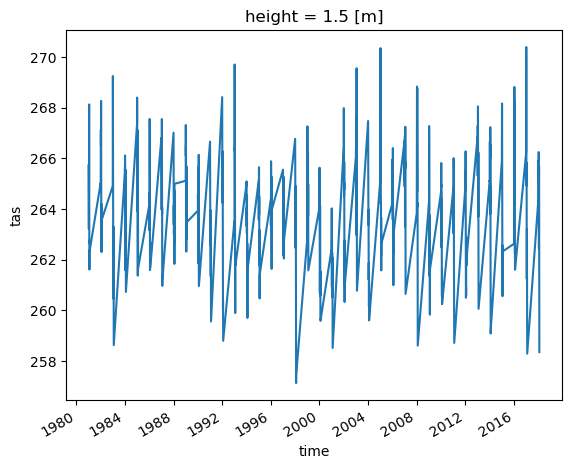

In [13]:
masked_da.mean(['grid_latitude','grid_longitude']).reset_index('time').plot()

ERROR:fiona._env:PROJ: proj_identify: /home/jez/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


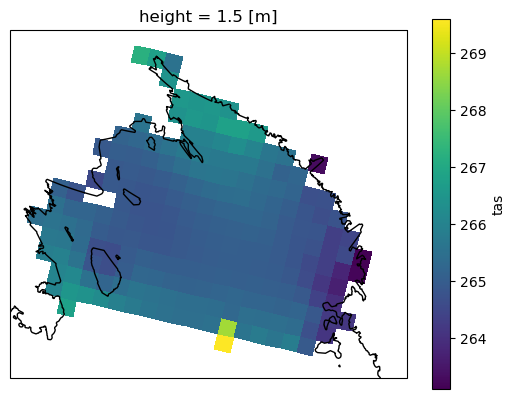

In [71]:
#Plotting Masked Climate Data and Antarctica Shapefile and Ross Ice Shelf Shapefile
map_proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=-90, globe=None)

da = ds.tas.isel(time=(ds.time.dt.month == 1))
masked_da = da.where(ds.ross_mask)
masked_da = masked_da.dropna('grid_latitude','all').dropna('grid_longitude','all')

masked_da.mean('time').plot(x='longitude',y='latitude',
    subplot_kws={"projection": map_proj},
    transform=ccrs.PlateCarree())

plt.gca().coastlines()

In [100]:
#Masking dataset and filtering to Jan 
ds_jan = ds.isel(time=(ds.time.dt.month == 1))

ds_jan['Mean Temperature'] = ds_jan['tas'].mean(['time'])
ds_jan['Variance Temperature'] = ds_jan['tas'].var(['time'])

params = ['Mean Temperature','Variance Temperature']
ds_jan = ds_jan[params+['ross_mask']]

ds_jan = ds_jan.stack(sites=('grid_latitude', 'grid_longitude'))
ds_jan_masked = ds_jan.where(ds_jan.ross_mask,drop=True)

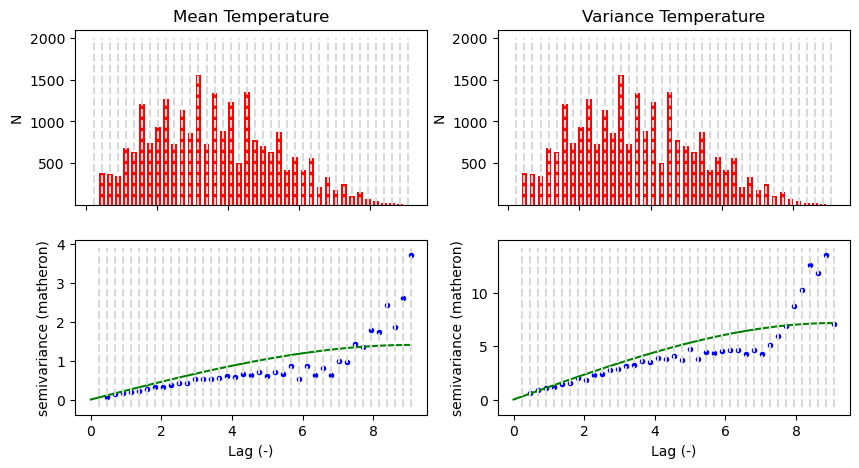

In [101]:
#Plot Semivariograms for Parameters (Ross Mask)
fig, axs = plt.subplots(2,2,figsize=(10,5))

for param in params:
    da = ds_jan_masked[param]#.dropna('Station_Lower')
    x,y = da.grid_latitude,da.grid_longitude
    coords = np.dstack([x,y]).reshape(-1,2)
    semivariogram = skg.Variogram(coords, da.data,n_lags=40)
    semivariogram.plot(axes=axs[:,params.index(param)][::-1])
    axs[:,params.index(param)][0].set_title(param)
plt.show()

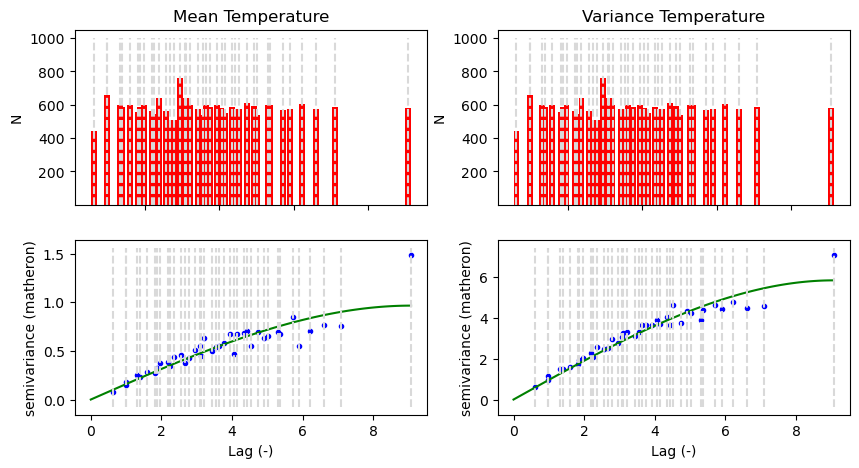

In [102]:
#Plot Semivariograms for Parameters (Ross Mask) - Uniform Bins
fig, axs = plt.subplots(2,2,figsize=(10,5))

for param in params:
    da = ds_jan_masked[param]#.dropna('Station_Lower')
    x,y = da.grid_latitude,da.grid_longitude
    coords = np.dstack([x,y]).reshape(-1,2)
    semivariogram = skg.Variogram(coords, da.data,n_lags=40,bin_func='uniform')
    semivariogram.plot(axes=axs[:,params.index(param)][::-1])
    axs[:,params.index(param)][0].set_title(param)
plt.show()